In [1]:
import os
from parser import get_historical_data, get_statistics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from exceptions import FileNotFoundError
from datetime import datetime

In [2]:
input_file_path = "input.csv"

if not os.path.exists(input_file_path):
    raise FileNotFoundError("input.csv", input_file_path)

tickers_df = pd.read_csv(input_file_path)
tickers_data_df = pd.DataFrame(
    columns=[
        "ticker", "timestamp", "open_price", "highest_price", "lowest_price",
        "close_price", "volume"
    ]
)

tickers_stat_df = pd.DataFrame(
    columns=[
        "ticker", "market_cap", "enterprise_value", "trailing_pe",
        "forward_pe", "peg_ratio", "price_sales", "price_book",
        "enterprise_value_revenue", "enterprise_value_ebitda"
    ]
)

tickers = list(tickers_df["Tickers"].values)

for ticker in tickers:
    result = get_historical_data(
        ticker=ticker,
        interval="1d",
        start=datetime(2025, 1, 1)
    )
    
    result = result["chart"]["result"][0]
    open_prices = result["indicators"]["quote"][0]["open"]
    highest_prices = result["indicators"]["quote"][0]["high"]
    lowest_prices = result["indicators"]["quote"][0]["low"]
    close_prices = result["indicators"]["adjclose"][0]["adjclose"]
    volumes = result["indicators"]["quote"][0]["volume"]

    for i, timestamp in enumerate(result["timestamp"]):   
        tickers_data_df.loc[-1] = [
            ticker, timestamp, open_prices[i], highest_prices[i],
            lowest_prices[i], close_prices[i], volumes[i]
        ]
        
        tickers_data_df.index += 1
        tickers_data_df = tickers_data_df.sort_index()
    
    result = get_statistics(ticker=ticker)
    tickers_stat_df.loc[-1] = [ticker, *result.values()]
    tickers_stat_df.index += 1
    tickers_stat_df = tickers_stat_df.sort_index()
    
tickers_data_df = tickers_data_df.sort_values(["ticker", "timestamp"])

In [3]:
for ticker in tickers:
    mask = tickers_data_df["ticker"] == ticker
    tickers_data_df.loc[mask, "d_close_price"] = \
        tickers_data_df.loc[mask, "close_price"].diff()
        
    tickers_data_df.loc[mask, "day_range"] = \
        tickers_data_df.loc[mask, "highest_price"] - tickers_data_df.loc[mask, "lowest_price"]

In [4]:
def analyze_correlation(df, ticker):
    df = df.copy()
    df["prev_close"] = df["close_price"].shift(1)
    
    corr_matrix = df[["close_price", "prev_close", "day_range", "volume", "highest_price", "lowest_price"]].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title(f"Корреляция для {ticker}")
    plt.tight_layout()
    plt.show()

In [5]:
def analyze_avg_correlation(df: pd.DataFrame):
    df = df.copy()
    corr_matrixes = []
    
    for ticker in df["ticker"].unique():
        mask = df["ticker"] == ticker
        df.loc[mask, "prev_close"] = df.loc[mask, "close_price"].shift(1)
    
        corr_matrix = df.loc[mask, ["close_price", "prev_close", "day_range", "volume", "highest_price", "lowest_price"]].corr()
        corr_matrixes.append(corr_matrix)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(sum(corr_matrixes) / len(df["ticker"].unique()), annot=True, cmap="coolwarm")
    plt.title(f"Средняя корреляция")
    plt.tight_layout()
    plt.show()

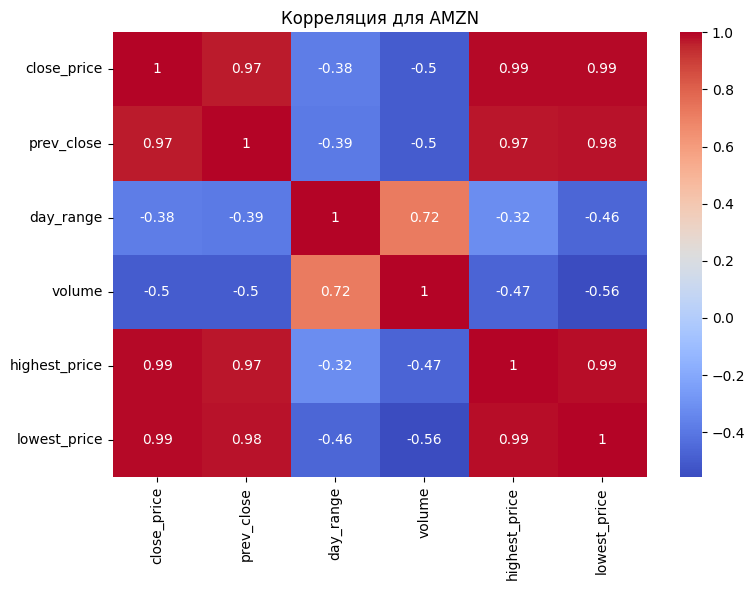

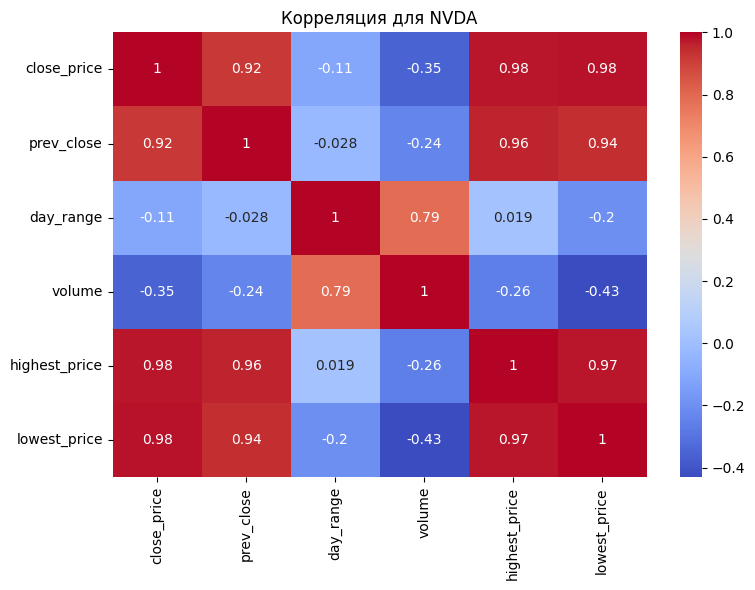

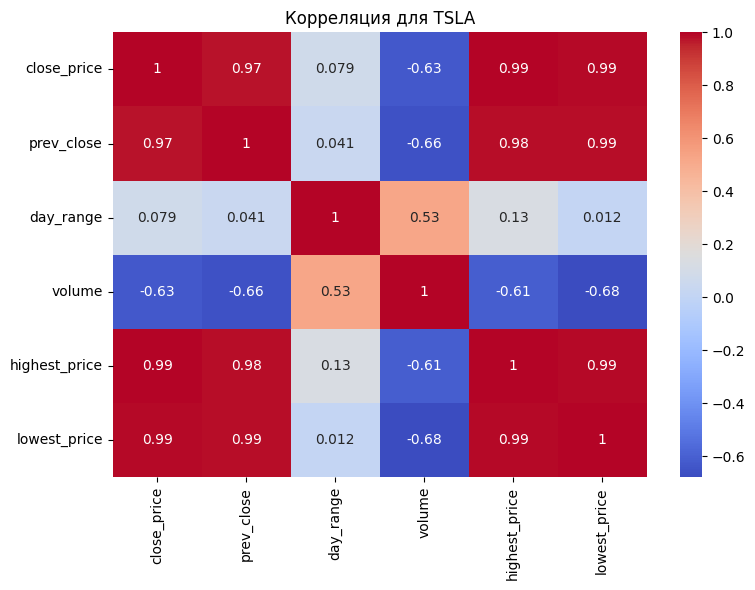

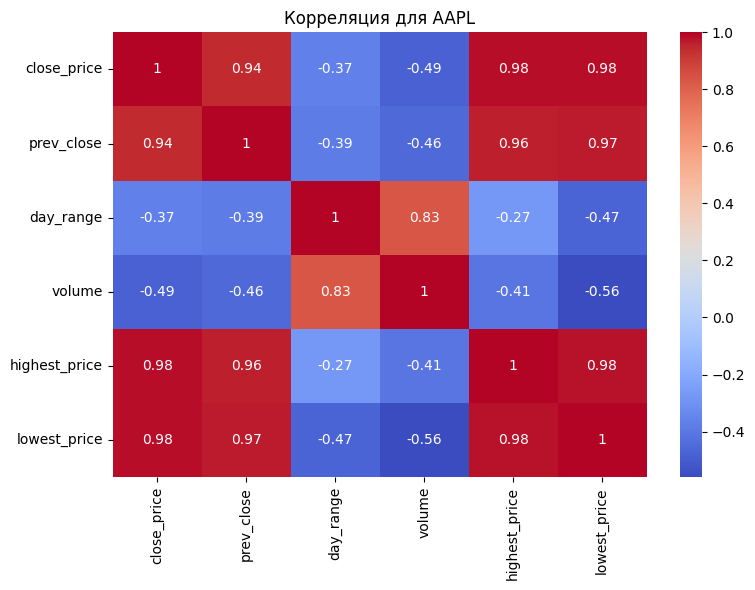

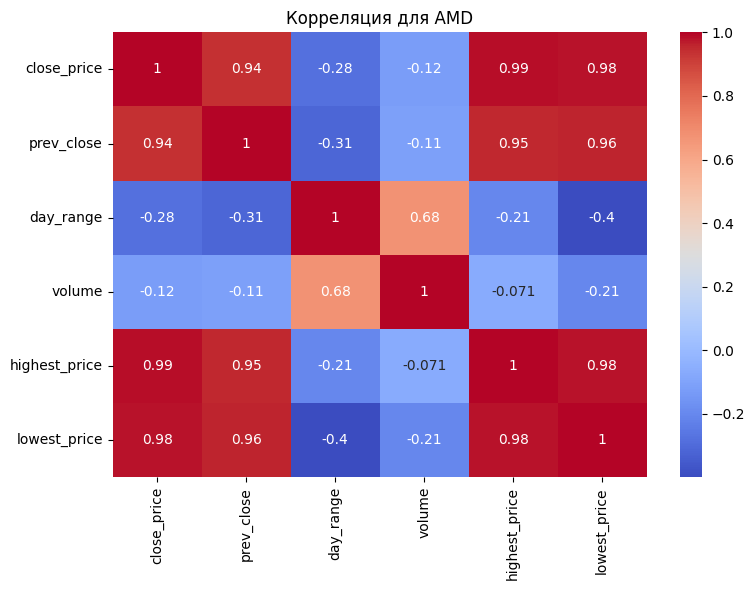

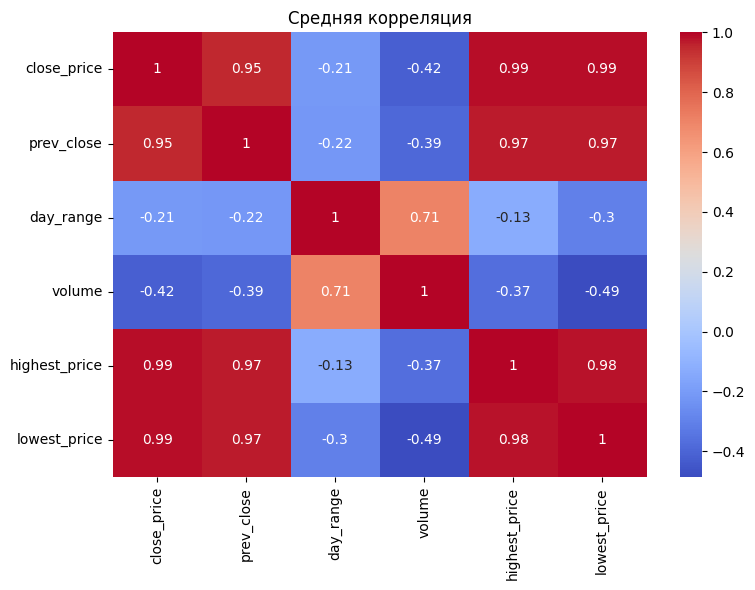

In [6]:
for ticker in tickers:
    analyze_correlation(tickers_data_df[tickers_data_df["ticker"] == ticker], ticker)
    
analyze_avg_correlation(tickers_data_df)

# Анализ корреляции
- Цена закрытия и цена закрытия на предыдущий день имееют высокую положительную корреляцию (0,95), что может указывать на стабильность рынка и малое кол-во/отсутсвие больших скачков цены.
- Объём торговли имеет умеренную отрицательную корреляцию с ценой закрытия, что может указывать на то, что при больших объёмах цена, как правило, снижается. При повышении цены, объёмы уменьшаются.
- Разница между самой высокой и самой низкой ценой в течении дня и объёмом имеют высокую положительную корреляцию (0,71), что может указывать на то, что при больших объёмах волатильность рынка также увеличивается.

In [7]:
tickers_stat_df

,ticker,market_cap,enterprise_value,trailing_pe,forward_pe,peg_ratio,price_sales,price_book,enterprise_value_revenue,enterprise_value_ebitda
0,AMD,189980000000,187400000000,85.53,28.99,0.59,6.90,3.28,6.75,31.38
1,AAPL,3160000000000,3210000000000,32.91,29.33,2.14,8.02,47.24,8.01,23.08
2,TSLA,1130000000000,1100000000000,199.99,163.93,5.51,12.82,15.10,11.53,80.98
3,NVDA,3300000000000,3270000000000,46.05,31.45,1.94,25.74,41.63,25.05,37.95
4,AMZN,2180000000000,2220000000000,33.48,31.85,2.27,3.40,7.14,3.42,16.46


PEG < 1 у AMD, что может говорить о том, что акции компании недооценены.
У Apple P/E ниже среднего по сектору (47), при этом PEG немного выше, можно сказать, что компания стабильная.
P/E и Forward P/E у Tesla сильно выше среднего + PEG также выше среднего по отрасли (1,70), можно сказать, что акции компании переоценены. Однако, это так же означает, что инвесторы имеют большие ожидания относительно роста компании. Однако, при сравнении Trailing P/E и Forward P/E, видно что аналитики ждут падения прибыли компании
P/E у Nvidia выше среднего, т.к. многие инвесторы имеют большие ожидания в области ИИ в будущем.

In [8]:
tickers_data_df.to_csv("output.csv")
tickers_stat_df.to_csv("output_stat.csv")